The script below performs the following:
1. Merge 3 datasets (RAP, ADS-B and ARTCC for CONUS)
2. Perform data exploration to answer Dr. Sherry's Questions
3. Prepare data for visualization of merged dataset

In [2]:
pip install awswrangler

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sagemaker
import boto3
import awswrangler as wr

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [4]:
from sagemaker import get_execution_role
role = get_execution_role()

asdb_conus_rapCell = wr.s3.read_csv(path= 's3://partly-cloudy-common-area/proof_of_concept/adbs-conus-rap-merge/*.csv')
asdb_conus_rapCell

output_bucket = 'partly-cloudy-common-area'
output_subfolder = 'proof_of_concept'
outputFileName = 'asdb_conus_rapCell.csv' # <------------------ Specify

wr.s3.to_csv(asdb_conus_rapCell, f"s3://{output_bucket}/{output_subfolder}/{outputFileName}", index=False)

## 0. Data Import & Pre-Process

### 0.a - Import 'asdb_conus_rapCell.csv' (ads-b data within RAP CONUS with RAP Cell attributes)

In [10]:
# This dataset is adsb data records with the closest RAP Cell
asdb_conus_rapCell = wr.s3.read_csv(path= 's3://partly-cloudy-common-area/proof_of_concept/asdb_conus_rapCell.csv')
asdb_conus_rapCell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130105 entries, 0 to 3130104
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   DateTime          object 
 1   id                int64  
 2   Altitude          float64
 3   Latitude          float64
 4   Longitude         float64
 5   hPa               int64  
 6   Nx                int64  
 7   Ny                int64  
 8   distToCellCenter  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 214.9+ MB


In [11]:
# Add Fields in raw data ('asdb_conus_rapCell')
asdb_conus_rapCell['DateTime'] = pd.to_datetime(asdb_conus_rapCell['DateTime'])
asdb_conus_rapCell['hour'] = [row.hour for row in asdb_conus_rapCell['DateTime']]
asdb_conus_rapCell['cellCenterAlt'] = (1 - (asdb_conus_rapCell['hPa']/1013.25)**0.190284) * 145366.45
asdb_conus_rapCell['FL'] = round(asdb_conus_rapCell['cellCenterAlt']/100,-1).astype(np.int)
asdb_conus_rapCell

,DateTime,id,Altitude,Latitude,Longitude,hPa,Nx,Ny,distToCellCenter,hour,cellCenterAlt,FL
0,2016-06-20 00:00:00,4196601,2350.0,36.076401,-115.127663,925,75,98,10.470790,0,2498.860178,20
1,2016-06-20 00:00:00,11069170,10675.0,35.138141,-80.789509,675,230,89,10.045923,0,10812.750233,110
2,2016-06-20 00:00:00,10700817,7400.0,30.632210,-81.586450,775,228,64,7.585762,0,7228.727982,70
3,2016-06-20 00:00:00,11281093,1575.0,40.742472,-73.840173,950,256,124,7.823334,0,1772.030170,20
4,2016-06-20 00:00:00,12598340,37000.0,45.256130,-81.588492,225,220,146,4.413524,0,36195.496603,360
...,...,...,...,...,...,...,...,...,...,...,...,...
3130100,2016-06-20 12:34:00,10776204,23025.0,43.864684,-91.217194,400,181,135,9.306994,12,23564.346609,240
3130101,2016-06-20 12:34:00,10494088,35000.0,32.587218,-78.873989,250,240,76,3.394100,12,33984.704039,340
3130102,2016-06-20 12:34:00,10768141,16350.0,44.704300,-94.110628,550,169,140,6.422707,12,15955.335092,160
3130103,2016-06-20 12:34:00,11038261,36000.0,39.829210,-87.676697,225,197,113,2.614560,12,36195.496603,360


### 0.b - Import 'latlonRAP.csv' (Lat/Lon of RAP Cell in Single Level)

In [12]:
latlonRAP = wr.s3.read_csv(path= 's3://partly-cloudy-common-area/proof_of_concept/latlonRAP.csv')
latlonRAP

,Nx,Ny,Lat,Lon
0,1,1,16.281000,-126.138000
1,2,1,16.322011,-125.954684
2,3,1,16.362789,-125.771252
3,4,1,16.403332,-125.587705
4,5,1,16.443642,-125.404045
...,...,...,...,...
67720,297,225,55.648911,-58.431595
67721,298,225,55.607604,-58.167947
67722,299,225,55.565986,-57.904583
67723,300,225,55.524058,-57.641507


### 0.c - Import 'rapCellNxNy_ARTCC_intersect.csv' (RAP Cells in Single Level with Center Identification & Name)

In [13]:
rapCell_center = wr.s3.read_csv(path= 's3://partly-cloudy-common-area/proof_of_concept/rapCellNxNy_ARTCC_intersect.csv')
rapCell_center

,IDENT,NAME,Nx,Ny
0,ZMA,MIAMI,233,28
1,ZMA,MIAMI,242,29
2,ZMA,MIAMI,232,28
3,ZMA,MIAMI,241,29
4,ZMA,MIAMI,249,30
...,...,...,...,...
25318,ZSE,SEATTLE,76,173
25319,ZLC,SALT LAKE CITY,114,168
25320,ZLC,SALT LAKE CITY,126,167
25321,ZMP,MINNEAPOLIS,144,166


#### 0.c.i - Summarize total number of cells on Single Level in each Center

In [14]:
rapCell_center_cells = rapCell_center
rapCell_center_cells = rapCell_center.groupby(['IDENT'])['NAME'].aggregate('count')
rapCell_center_cells = rapCell_center_cells.reset_index().copy()
rapCell_center_cells.rename(columns = {'NAME': 'TotNumCellsSingleLevel'}, inplace = True)

rapCell_center_cells

,IDENT,TotNumCellsSingleLevel
0,ZAB,1522
1,ZAU,690
2,ZBW,1070
3,ZDC,796
4,ZDV,1806
5,ZFW,1038
6,ZHU,1421
7,ZID,629
8,ZJX,1264
9,ZKC,1165


### 0.d - Merge 'asdb_conus_rapCell' and 'rapCell_center' to get Cell Center Lat/Long

In [15]:
asdb_conus_rapCell_center = pd.merge(asdb_conus_rapCell, rapCell_center,
                                     how= 'left',
                                     on= ['Nx', 'Ny'])
asdb_conus_rapCell_center

,DateTime,id,Altitude,Latitude,Longitude,hPa,Nx,Ny,distToCellCenter,hour,cellCenterAlt,FL,IDENT,NAME
0,2016-06-20 00:00:00,4196601,2350.0,36.076401,-115.127663,925,75,98,10.470790,0,2498.860178,20,ZLA,LOS ANGELES
1,2016-06-20 00:00:00,11069170,10675.0,35.138141,-80.789509,675,230,89,10.045923,0,10812.750233,110,ZTL,ATLANTA
2,2016-06-20 00:00:00,10700817,7400.0,30.632210,-81.586450,775,228,64,7.585762,0,7228.727982,70,ZJX,JACKSONVILLE
3,2016-06-20 00:00:00,11281093,1575.0,40.742472,-73.840173,950,256,124,7.823334,0,1772.030170,20,ZNY,NEW YORK
4,2016-06-20 00:00:00,12598340,37000.0,45.256130,-81.588492,225,220,146,4.413524,0,36195.496603,360,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130178,2016-06-20 12:34:00,10776204,23025.0,43.864684,-91.217194,400,181,135,9.306994,12,23564.346609,240,ZMP,MINNEAPOLIS
3130179,2016-06-20 12:34:00,10494088,35000.0,32.587218,-78.873989,250,240,76,3.394100,12,33984.704039,340,ZJX,JACKSONVILLE
3130180,2016-06-20 12:34:00,10768141,16350.0,44.704300,-94.110628,550,169,140,6.422707,12,15955.335092,160,ZMP,MINNEAPOLIS
3130181,2016-06-20 12:34:00,11038261,36000.0,39.829210,-87.676697,225,197,113,2.614560,12,36195.496603,360,ZID,INDIANAPOLIS


### 0.e - Drop Duplicates in Merged Dataset (an aircraft cannot be in a NOAA Cell more than once during a specific hour)

In [16]:
asdbConusRapCellCenter_noDup = asdb_conus_rapCell_center.drop_duplicates(subset= ['Nx', 'Ny', 'hPa', 'id', 'hour']).copy()
asdbConusRapCellCenter_noDup

,DateTime,id,Altitude,Latitude,Longitude,hPa,Nx,Ny,distToCellCenter,hour,cellCenterAlt,FL,IDENT,NAME
0,2016-06-20 00:00:00,4196601,2350.0,36.076401,-115.127663,925,75,98,10.470790,0,2498.860178,20,ZLA,LOS ANGELES
1,2016-06-20 00:00:00,11069170,10675.0,35.138141,-80.789509,675,230,89,10.045923,0,10812.750233,110,ZTL,ATLANTA
2,2016-06-20 00:00:00,10700817,7400.0,30.632210,-81.586450,775,228,64,7.585762,0,7228.727982,70,ZJX,JACKSONVILLE
3,2016-06-20 00:00:00,11281093,1575.0,40.742472,-73.840173,950,256,124,7.823334,0,1772.030170,20,ZNY,NEW YORK
4,2016-06-20 00:00:00,12598340,37000.0,45.256130,-81.588492,225,220,146,4.413524,0,36195.496603,360,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130175,2016-06-20 12:34:00,10911793,24675.0,39.186789,-75.860107,375,249,114,10.990549,12,25051.008094,250,ZDC,WASHINGTON
3130176,2016-06-20 12:34:00,10706405,35375.0,42.260680,-84.128191,225,211,128,4.864503,12,36195.496603,360,ZOB,CLEVELAND
3130180,2016-06-20 12:34:00,10768141,16350.0,44.704300,-94.110628,550,169,140,6.422707,12,15955.335092,160,ZMP,MINNEAPOLIS
3130181,2016-06-20 12:34:00,11038261,36000.0,39.829210,-87.676697,225,197,113,2.614560,12,36195.496603,360,ZID,INDIANAPOLIS


In [22]:
# Total flight-cells in each Flight Level
asdbConusRapCellCenter_noDup['FL'].value_counts()

340    286716
360    246714
390    153666
320    100775
410     77925
20      77486
280     69458
60      69203
300     68009
270     62706
240     62432
250     53267
220     46268
200     45258
110     43572
100     42496
210     42107
120     39329
40      38499
170     38202
160     37028
50      36237
180     36158
30      35570
130     35143
150     34827
80      34054
140     33654
90      32788
10      32778
70      32719
0       27885
440     27726
480      2103
520       960
Name: FL, dtype: int64

### 0.f - Make a Dataset for Flight Levels >= 200 & <= 430 (13 Pressure Levels)

In [20]:
asdbConusRapCellCenter_noDup_fl200_430 = asdbConusRapCellCenter_noDup.loc[(asdbConusRapCellCenter_noDup['FL'] >= 200) & (asdbConusRapCellCenter_noDup['FL'] <= 430)].copy()
asdbConusRapCellCenter_noDup_fl200_430

,DateTime,id,Altitude,Latitude,Longitude,hPa,Nx,Ny,distToCellCenter,hour,cellCenterAlt,FL,IDENT,NAME
4,2016-06-20 00:00:00,12598340,37000.0,45.256130,-81.588492,225,220,146,4.413524,0,36195.496603,360,NaN,NaN
17,2016-06-20 00:00:00,11265243,37000.0,39.497681,-95.266989,225,164,110,5.389977,0,36195.496603,360,ZKC,KANSAS CITY
18,2016-06-20 00:00:00,11232022,35025.0,38.304392,-106.230747,250,115,106,12.632220,0,33984.704039,340,ZDV,DENVER
19,2016-06-20 00:00:00,7701239,39000.0,38.025683,-125.786650,200,30,117,7.670891,0,38615.045787,390,ZOA,OAKLAND
21,2016-06-20 00:00:00,10669717,22725.0,39.450348,-79.288151,425,234,114,9.695458,0,22151.114492,220,ZDC,WASHINGTON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130174,2016-06-20 12:34:00,11129932,36975.0,33.807399,-83.846111,225,216,80,11.410820,12,36195.496603,360,ZTL,ATLANTA
3130175,2016-06-20 12:34:00,10911793,24675.0,39.186789,-75.860107,375,249,114,10.990549,12,25051.008094,250,ZDC,WASHINGTON
3130176,2016-06-20 12:34:00,10706405,35375.0,42.260680,-84.128191,225,211,128,4.864503,12,36195.496603,360,ZOB,CLEVELAND
3130181,2016-06-20 12:34:00,11038261,36000.0,39.829210,-87.676697,225,197,113,2.614560,12,36195.496603,360,ZID,INDIANAPOLIS


In [21]:
asdbConusRapCellCenter_noDup_fl200_430['hPa'].value_counts()

250    286716
225    246714
200    153666
275    100775
175     77925
325     69458
300     68009
350     62706
400     62432
375     53267
425     46268
475     45258
450     42107
Name: hPa, dtype: int64

## 1. Cells have Flight Track(s) - Daily

   ###    1.a - Looking at the grid for the whole CONUS, what percent of cells have at least one flight track that passes through? and Rank?

In [30]:
# Counting the number of flights in each NOAA Cell
df1 = asdbConusRapCellCenter_noDup.groupby(['Nx', 'Ny', 'hPa', 'FL'])['id'].aggregate('count')
dailyPlaneCountsInCells = df1.reset_index().copy()
dailyPlaneCountsInCells.rename(columns = {'id': 'dailyPlanesInCells'}, inplace = True)

dailyPlaneCountsInCells.sort_values(by= ['dailyPlanesInCells'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,hPa,FL,dailyPlanesInCells
26204,58,88,1000,0,1880
26203,58,88,975,10,1276
76260,123,114,850,50,1170
23847,56,167,1000,0,1154
26202,58,88,950,20,1107
...,...,...,...,...,...
213252,229,84,625,130,1
213251,229,84,550,160,1
100756,155,60,900,30,1
100757,155,60,925,20,1


In [31]:
# NOAA RAP Cells with at least one aircraft traversed is len(dailyPlaneCountsInCells)
# Number of NOAA RAP Cells in a single pressure level is (len(latlonRAP)
# 37 different pressure levels

len(dailyPlaneCountsInCells)/(len(latlonRAP)*37)

0.11396925164367025

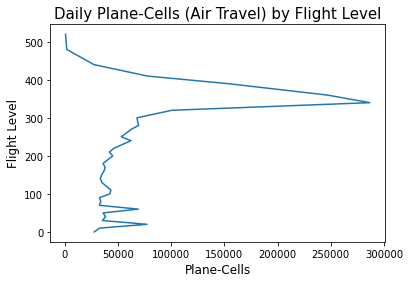

In [32]:
# Graph Flight-Cells by Flight Level
df2 = dailyPlaneCountsInCells.groupby(['FL'])['dailyPlanesInCells'].aggregate('sum')
df2 = df2.reset_index().copy()

plt.plot(df2['dailyPlanesInCells'], df2['FL'])
plt.title("Daily Plane-Cells (Air Travel) by Flight Level", fontsize= 15)
plt.xlabel("Plane-Cells", fontsize= 12)
plt.ylabel("Flight Level", fontsize= 12)
plt.show()

   ###    1.b - Looking at the grid for the whole CONUS from FL200 to FL430 that passes through? and Rank?

In [33]:
# Counting the number of flights in each NOAA Cell
df1 = asdbConusRapCellCenter_noDup_fl200_430.groupby(['Nx', 'Ny', 'hPa', 'FL'])['id'].aggregate('count')
dailyPlaneCountsInCells_sel = df1.reset_index().copy()
dailyPlaneCountsInCells_sel.rename(columns = {'id': 'dailyPlanesInCells'}, inplace = True)

dailyPlaneCountsInCells_sel.sort_values(by= ['dailyPlanesInCells'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,hPa,FL,dailyPlanesInCells
152359,249,113,350,270,224
155816,254,125,475,200,214
20805,66,87,400,240,201
102799,202,129,475,200,188
20200,65,87,450,210,183
...,...,...,...,...,...
79225,169,130,350,270,1
79232,169,131,350,270,1
79233,169,131,375,250,1
79234,169,131,400,240,1


In [34]:
# NOAA RAP Cells with at least one aircraft traversed is len(dailyPlaneCountsInCells_sel)
# Number of NOAA RAP Cells in a single pressure level is (len(latlonRAP)
# 13 different pressure levels
len(dailyPlaneCountsInCells_sel)/(len(latlonRAP)*13)

0.19798619984666496

   ###    1.c - Looking at the grid for each of 20 Centers the CONUS, what percent of the cells in each Center at least on flight track that passes through?

In [40]:
# Counting the number of flights in each NOAA Cell in ARTCC
df1 = asdbConusRapCellCenter_noDup.groupby(['Nx', 'Ny', 'hPa', 'FL', 'IDENT', 'NAME'])['id'].aggregate('count')
dailyPlaneCountsInCellsCenters = df1.reset_index().copy()
dailyPlaneCountsInCellsCenters.rename(columns = {'id': 'dailyPlanesInCells'}, inplace = True)
dailyPlaneCountsInCellsCenters.sort_values(by= ['dailyPlanesInCells'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,hPa,FL,IDENT,NAME,dailyPlanesInCells
23437,58,88,1000,0,ZLA,LOS ANGELES,1880
23436,58,88,975,10,ZLA,LOS ANGELES,1276
64496,123,114,850,50,ZDV,DENVER,1170
21346,56,167,1000,0,ZSE,SEATTLE,1154
23435,58,88,950,20,ZLA,LOS ANGELES,1107
...,...,...,...,...,...,...,...
119942,175,150,350,270,ZMP,MINNEAPOLIS,1
119941,175,150,225,360,ZMP,MINNEAPOLIS,1
119940,175,149,250,340,ZMP,MINNEAPOLIS,1
119938,175,148,300,300,ZMP,MINNEAPOLIS,1


In [43]:
# NOAA RAP Cells with at least one aircraft traversed in ARTCC is len(dailyPlaneCountsInCellsCenters)
# Number of NOAA RAP Cells in a single pressure level for ARTCC is len(rapCell_center)
# 37 Pressure Levels
len(dailyPlaneCountsInCellsCenters)/(len(rapCell_center)*37)

0.26736830421228003

In [44]:
# Summarizing the total number of flights in NOAA Cells for each Center
dailyPlaneCountsInCenters = dailyPlaneCountsInCellsCenters.groupby(['IDENT', 'NAME'])['dailyPlanesInCells'].aggregate(['count', 'sum'])
dailyPlaneCountsInCenters = dailyPlaneCountsInCenters.reset_index().copy()
dailyPlaneCountsInCenters.rename(columns = {'count': 'numOfTraversedCells', 'sum': 'dailyPlanesInCells'}, inplace = True)

dailyPlaneCountsInCenters

,IDENT,NAME,numOfTraversedCells,dailyPlanesInCells
0,ZAB,ALBUQUERQUE,9674,80751
1,ZAU,CHICAGO,16146,145875
2,ZBW,BOSTON,17499,121149
3,ZDC,WASHINGTON,12091,147022
4,ZDV,DENVER,13431,100373
5,ZFW,FORT WORTH,14341,113372
6,ZHU,HOUSTON,16153,93997
7,ZID,INDIANAPOLIS,12691,104100
8,ZJX,JACKSONVILLE,15157,110762
9,ZKC,KANSAS CITY,15098,92676


In [45]:
# Summarizing the percent of cells traversed for each Center
dailyPlaneCountsInCenters_comb = dailyPlaneCountsInCenters.merge(rapCell_center_cells, on= 'IDENT')
dailyPlaneCountsInCenters_comb['TotNumCellsAllLevels'] = dailyPlaneCountsInCenters_comb['TotNumCellsSingleLevel'] *37
dailyPlaneCountsInCenters_comb['percTravesedCells'] = dailyPlaneCountsInCenters_comb['numOfTraversedCells'] /(dailyPlaneCountsInCenters_comb['TotNumCellsAllLevels'])

dailyPlaneCountsInCenters_comb.sort_values(by= ['percTravesedCells'], axis= 0, ascending= False, inplace= False)

,IDENT,NAME,numOfTraversedCells,dailyPlanesInCells,TotNumCellsSingleLevel,TotNumCellsAllLevels,percTravesedCells
1,ZAU,CHICAGO,16146,145875,690,25530,0.632432
17,ZOB,CLEVELAND,13556,129899,600,22200,0.610631
7,ZID,INDIANAPOLIS,12691,104100,629,23273,0.545310
2,ZBW,BOSTON,17499,121149,1070,39590,0.442006
19,ZTL,ATLANTA,11080,80906,696,25752,0.430258
3,ZDC,WASHINGTON,12091,147022,796,29452,0.410532
5,ZFW,FORT WORTH,14341,113372,1038,38406,0.373405
9,ZKC,KANSAS CITY,15098,92676,1165,43105,0.350261
8,ZJX,JACKSONVILLE,15157,110762,1264,46768,0.324089
6,ZHU,HOUSTON,16153,93997,1421,52577,0.307226


output_bucket = 'partly-cloudy-common-area'

outputFileName = 'dailyPlaneCountsInCenters_comb.csv'
wr.s3.to_csv(dailyPlaneCountsInCenters_comb, f"s3://{output_bucket}/{outputFileName}", index=False)

   ###    1.d - Looking at the grid for each FL in each of 20 Centers the CONUS, what percent of the cells in each FL in each Center at least on flight track that passes through?

In [46]:
# Counting the number of flights in each NOAA Cell in ARTCC (for FL200 to FL430)
df1 = asdbConusRapCellCenter_noDup_fl200_430.groupby(['Nx', 'Ny', 'hPa', 'FL', 'IDENT', 'NAME'])['id'].aggregate('count')
dailyPlaneCountsInCellsCenters_sel = df1.reset_index().copy()
dailyPlaneCountsInCellsCenters_sel.rename(columns = {'id': 'dailyPlanesInCells'}, inplace = True)

dailyPlaneCountsInCellsCenters_sel.sort_values(by= ['dailyPlanesInCells'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,hPa,FL,IDENT,NAME,dailyPlanesInCells
135735,249,113,350,270,ZDC,WASHINGTON,224
138479,254,125,475,200,ZNY,NEW YORK,214
18148,66,87,400,240,ZLA,LOS ANGELES,201
91635,202,129,475,200,ZAU,CHICAGO,188
17665,65,87,450,210,ZLA,LOS ANGELES,183
...,...,...,...,...,...,...,...
70110,171,126,450,210,ZMP,MINNEAPOLIS,1
70111,171,126,475,200,ZMP,MINNEAPOLIS,1
70117,171,127,300,300,ZMP,MINNEAPOLIS,1
70119,171,127,350,270,ZMP,MINNEAPOLIS,1


In [48]:
# NOAA RAP Cells with at least one aircraft traversed in ARTCC is len(dailyPlaneCountsInCellsCenters_sel)
# Number of NOAA RAP Cells in a single pressure level for ARTCC is len(rapCell_center)
# 13 Pressure Levels
len(dailyPlaneCountsInCellsCenters_sel)/(len(rapCell_center)*13)

0.45079723814470885

In [49]:
# Summarizing the total number of flights in NOAA Cells for each Center
dailyPlaneCountsInCenters_sel = dailyPlaneCountsInCellsCenters_sel.groupby(['IDENT', 'NAME'])['dailyPlanesInCells'].aggregate(['count', 'sum'])
dailyPlaneCountsInCenters_sel = dailyPlaneCountsInCenters_sel.reset_index().copy()
dailyPlaneCountsInCenters_sel.rename(columns = {'count': 'numOfTraversedCells', 'sum': 'dailyPlanesInCells'}, inplace = True)

dailyPlaneCountsInCenters_sel

,IDENT,NAME,numOfTraversedCells,dailyPlanesInCells
0,ZAB,ALBUQUERQUE,6048,51207
1,ZAU,CHICAGO,8306,87208
2,ZBW,BOSTON,9624,65191
3,ZDC,WASHINGTON,6665,87331
4,ZDV,DENVER,8964,71222
5,ZFW,FORT WORTH,8168,64128
6,ZHU,HOUSTON,9160,48701
7,ZID,INDIANAPOLIS,7273,85125
8,ZJX,JACKSONVILLE,8444,78609
9,ZKC,KANSAS CITY,9541,76281


In [50]:
# Summarizing the percent of cells traversed for each Center
dailyPlaneCountsInCenters_selcomb = dailyPlaneCountsInCenters_sel.merge(rapCell_center_cells, on= 'IDENT')
dailyPlaneCountsInCenters_selcomb['TotNumCellsAppLevels'] = dailyPlaneCountsInCenters_selcomb['TotNumCellsSingleLevel'] *13
dailyPlaneCountsInCenters_selcomb['percTravesedCells'] = dailyPlaneCountsInCenters_selcomb['numOfTraversedCells'] /(dailyPlaneCountsInCenters_selcomb['TotNumCellsAppLevels'])

dailyPlaneCountsInCenters_selcomb
dailyPlaneCountsInCenters_selcomb.sort_values(by= ['percTravesedCells'], axis= 0, ascending= False, inplace= False)

,IDENT,NAME,numOfTraversedCells,dailyPlanesInCells,TotNumCellsSingleLevel,TotNumCellsAppLevels,percTravesedCells
17,ZOB,CLEVELAND,7340,93233,600,7800,0.941026
1,ZAU,CHICAGO,8306,87208,690,8970,0.925975
7,ZID,INDIANAPOLIS,7273,85125,629,8177,0.889446
19,ZTL,ATLANTA,6493,55208,696,9048,0.717617
2,ZBW,BOSTON,9624,65191,1070,13910,0.691876
3,ZDC,WASHINGTON,6665,87331,796,10348,0.644086
9,ZKC,KANSAS CITY,9541,76281,1165,15145,0.629977
5,ZFW,FORT WORTH,8168,64128,1038,13494,0.605306
8,ZJX,JACKSONVILLE,8444,78609,1264,16432,0.513875
6,ZHU,HOUSTON,9160,48701,1421,18473,0.495859


output_bucket = 'partly-cloudy-common-area'

outputFileName = 'dailyPlaneCountsInCenters_selcomb.csv'
wr.s3.to_csv(dailyPlaneCountsInCenters_selcomb, f"s3://{output_bucket}/{outputFileName}", index=False)

==============================================================================================

==============================================================================================

## Cells have Flight Track(s) - Hourly

   ###   A.'hourlyPlaneCountsInCells' is to be used with RAP Data (same time interval (Hour))

In [53]:
df1 = asdbConusRapCellCenter_noDup.groupby(['Nx', 'Ny', 'hPa', 'FL', 'hour'])['id'].aggregate('count')
hourlyPlaneCountsInCells = df1.reset_index().copy()
hourlyPlaneCountsInCells.rename(columns = {'id': 'hourlyPlanesInCells'}, inplace = True)

hourlyPlaneCountsInCells.sort_values(by= ['hourlyPlanesInCells'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,hPa,FL,hour,hourlyPlanesInCells
113293,58,88,1000,0,5,131
113294,58,88,1000,0,6,130
113303,58,88,1000,0,15,128
113302,58,88,1000,0,14,116
113292,58,88,1000,0,4,105
...,...,...,...,...,...,...
482330,166,107,975,10,1,1
482331,166,107,975,10,13,1
482334,166,107,975,10,19,1
482336,166,107,975,10,21,1


output_bucket = 'partly-cloudy-common-area'
output_subfolder = 'proof_of_concept'
outputFileName = 'hourlyPlaneCountsInCells.csv' # <------------------ Specify

wr.s3.to_csv(hourlyPlaneCountsInCells, f"s3://{output_bucket}/{output_subfolder}/{outputFileName}", index=False)

# For Visualization

   ###   A. 'hourlyPlaneCountsInRAPCells' and 'periodicPlaneCountsInRAPCells' are to be used for IDV (flight-hot spot detection)

In [68]:
# Hourly Plane Counts in RAP Cells Summary
hourlyPlaneCountsInRAPCells = hourlyPlaneCountsInCells.copy()
hourlyPlaneCountsInRAPCells['DateTime'] = [datetime(year= 2016, month= 6, day= 20, hour= h) for h in hourlyPlaneCountsInRAPCells['hour']]

hourlyPlaneCountsInRAPCells = hourlyPlaneCountsInRAPCells.merge(latlonRAP, on= ['Nx', 'Ny'])
hourlyPlaneCountsInRAPCells['cellCenterAlt'] = (1 - (hourlyPlaneCountsInRAPCells['hPa']/1013.25)**0.190284) * 145366.45

hourlyPlaneCountsInRAPCells


,Nx,Ny,hPa,FL,hour,hourlyPlanesInCells,DateTime,Lat,Lon,cellCenterAlt
0,1,69,300,300,9,1,2016-06-20 09:00:00,28.310934,-129.345860,30052.739831
1,1,69,300,300,10,1,2016-06-20 10:00:00,28.310934,-129.345860,30052.739831
2,1,73,250,340,7,1,2016-06-20 07:00:00,29.016869,-129.554817,33984.704039
3,1,73,250,340,8,1,2016-06-20 08:00:00,29.016869,-129.554817,33984.704039
4,1,141,300,300,9,1,2016-06-20 09:00:00,40.786688,-133.529271,30052.739831
...,...,...,...,...,...,...,...,...,...,...
1240939,301,187,250,340,2,1,2016-06-20 02:00:00,49.621836,-60.026348,33984.704039
1240940,301,187,250,340,12,1,2016-06-20 12:00:00,49.621836,-60.026348,33984.704039
1240941,301,188,175,410,22,1,2016-06-20 22:00:00,49.781012,-59.961350,41293.310257
1240942,301,188,200,390,23,1,2016-06-20 23:00:00,49.781012,-59.961350,38615.045787


In [69]:
# 6-Hour Time Period Plane Counts in RAP Cells Summary
increment = 6
periods = pd.DataFrame({'hour': [i for i in range(24)],
                        'period': [i//increment * increment for i in range(24)]})

df2 = asdbConusRapCellCenter_noDup.groupby(['Nx', 'Ny', 'hPa', 'FL', 'hour'])['id'].aggregate('count')
df3 = df2.reset_index().copy()
df3.rename(columns = {'id': 'hourlyPlanesInCells'}, inplace = True)
df3 = df3.merge(periods, on= 'hour')

df4 = df3.groupby(['Nx', 'Ny', 'hPa', 'FL', 'period'])['hourlyPlanesInCells'].aggregate('sum')
periodicPlaneCountsInRAPCells = df4.reset_index().copy()
periodicPlaneCountsInRAPCells.rename(columns = {'hourlyPlanesInCells': 'periodicPlanesInCells'}, inplace = True)
periodicPlaneCountsInRAPCells['DateTime'] = [datetime(year= 2016, month= 6, day= 20, hour= h) for h in periodicPlaneCountsInRAPCells['period']]

periodicPlaneCountsInRAPCells = periodicPlaneCountsInRAPCells.merge(latlonRAP, on= ['Nx', 'Ny'])
periodicPlaneCountsInRAPCells['cellCenterAlt'] = (1 - (periodicPlaneCountsInRAPCells['hPa']/1013.25)**0.190284) * 145366.45
periodicPlaneCountsInRAPCells

,Nx,Ny,hPa,FL,period,periodicPlanesInCells,DateTime,Lat,Lon,cellCenterAlt
0,1,69,300,300,6,2,2016-06-20 06:00:00,28.310934,-129.345860,30052.739831
1,1,73,250,340,6,2,2016-06-20 06:00:00,29.016869,-129.554817,33984.704039
2,1,141,300,300,6,2,2016-06-20 06:00:00,40.786688,-133.529271,30052.739831
3,1,142,175,410,0,1,2016-06-20 00:00:00,40.955056,-133.594367,41293.310257
4,1,203,250,340,6,2,2016-06-20 06:00:00,50.834640,-138.013356,33984.704039
...,...,...,...,...,...,...,...,...,...,...
609012,301,187,250,340,0,1,2016-06-20 00:00:00,49.621836,-60.026348,33984.704039
609013,301,187,250,340,12,1,2016-06-20 12:00:00,49.621836,-60.026348,33984.704039
609014,301,188,175,410,18,1,2016-06-20 18:00:00,49.781012,-59.961350,41293.310257
609015,301,188,200,390,18,1,2016-06-20 18:00:00,49.781012,-59.961350,38615.045787


output_bucket = 'partly-cloudy-common-area'

outputFileName = 'hourlyPlaneCountsInRAPCells.csv'
wr.s3.to_csv(hourlyPlaneCountsInRAPCells, f"s3://{output_bucket}/{outputFileName}", index=False)

outputFileName = 'periodicPlaneCountsInRAPCells.csv'
wr.s3.to_csv(periodicPlaneCountsInRAPCells, f"s3://{output_bucket}/{outputFileName}", index=False)

   ###   B. 'dailyPlaneCountsInAllLevels' and 'dailyPlaneCountsInAllLevels_sel' are to be used for Visualization (maps)

In [72]:
# For all 37 levels
df1 = asdbConusRapCellCenter_noDup.groupby(['Nx', 'Ny'])['id'].aggregate('count')
dailyPlaneCountsInAllLevels = df1.reset_index().copy()
dailyPlaneCountsInAllLevels.rename(columns = {'id': 'dailyPlanesInAllLevels'}, inplace = True)
dailyPlaneCountsInAllLevels.sort_values(by= ['dailyPlanesInAllLevels'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,dailyPlanesInAllLevels
2562,58,88,5937
15914,196,125,5115
22353,256,125,4654
22284,255,125,4595
11985,156,74,4027
...,...,...,...
8858,121,195,1
8857,121,193,1
8829,121,164,1
8810,121,135,1


In [73]:
dailyPlaneCountsInAllLevels = dailyPlaneCountsInAllLevels.merge(latlonRAP, on= ['Nx', 'Ny'])
dailyPlaneCountsInAllLevels.sort_values(by= ['dailyPlanesInAllLevels'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,dailyPlanesInAllLevels,Lat,Lon
2562,58,88,5937,33.874623,-118.374362
15914,196,125,5115,41.946647,-87.728842
22353,256,125,4654,40.845611,-73.809342
22284,255,125,4595,40.872773,-74.038493
11985,156,74,4027,33.004150,-96.941445
...,...,...,...,...,...
8858,121,195,1,53.459385,-106.726044
8857,121,193,1,53.143062,-106.680238
8829,121,164,1,48.436760,-106.054022
8810,121,135,1,43.530803,-105.491409


output_bucket = 'partly-cloudy-common-area'

outputFileName = 'dailyPlaneCountsInAllLevels.csv'
wr.s3.to_csv(dailyPlaneCountsInAllLevels, f"s3://{output_bucket}/{outputFileName}", index=False)

In [74]:
# For FL200 to FL430
df2 = asdbConusRapCellCenter_noDup_fl200_430.groupby(['Nx', 'Ny'])['id'].aggregate('count')
dailyPlaneCountsInAllLevels_sel = df2.reset_index().copy()
dailyPlaneCountsInAllLevels_sel.rename(columns = {'id': 'dailyPlanesInAppLevels'}, inplace = True)
dailyPlaneCountsInAllLevels_sel.sort_values(by= ['dailyPlanesInAppLevels'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,dailyPlanesInAppLevels
3297,66,92,661
21647,250,120,638
21719,251,117,598
17278,213,80,583
1922,52,111,572
...,...,...,...
5726,92,145,1
23702,279,90,1
23701,279,84,1
23700,278,179,1


In [75]:
dailyPlaneCountsInAllLevels_sel = dailyPlaneCountsInAllLevels_sel.merge(latlonRAP, on= ['Nx', 'Ny'])
dailyPlaneCountsInAllLevels_sel.sort_values(by= ['dailyPlanesInAppLevels'], axis= 0, ascending= False, inplace= False)

,Nx,Ny,dailyPlanesInAppLevels,Lat,Lon
3297,66,92,661,34.824630,-116.796976
21647,250,120,638,40.134943,-75.353748
21719,251,117,598,39.585984,-75.226292
17278,213,80,583,33.766129,-84.565976
1922,52,111,572,37.739097,-120.593738
...,...,...,...,...,...
5726,92,145,1,44.725285,-112.653421
23702,279,90,1,34.005882,-70.050213
23701,279,84,1,32.939982,-70.286917
23700,278,179,1,49.222689,-66.175349


output_bucket = 'partly-cloudy-common-area'

outputFileName = 'dailyPlaneCountsInAllLevels_sel.csv'
wr.s3.to_csv(dailyPlaneCountsInAllLevels_sel, f"s3://{output_bucket}/{outputFileName}", index=False)